In [ ]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=..., shuffle=True, random_state=42)
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     # Ở đây, bạn có thể đào tạo và kiểm tra mô hình trên X_train và X_test


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/MachineLearning/car_evaluation.csv', header=None)
data.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
data

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


# Thống kê mô tả

In [ ]:
# Xem thông tin các thuộc tính
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


⇒ Bộ dữ liệu không có giá trị null, kiểu dữ liệu tất cả các thuộc tính đều là object

In [ ]:
# Xem thông tinh các giá trị của thuộc tính class
data['class'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

<Axes: >

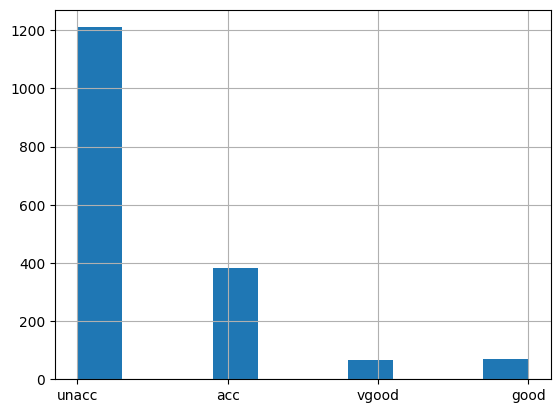

In [ ]:
# Biểu đồ histogram thể hiện phân phối của thuộc tính class.
data['class'].hist()

In [ ]:
# Xem thông tin thống kê của dữ liệu
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [ ]:
# Chuyển các dữ liệu phân loại thành số để dễ hơn trong việc tính toán
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in data.columns:
    data[col] = label_encoder.fit_transform(data[col])

data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


<Axes: >

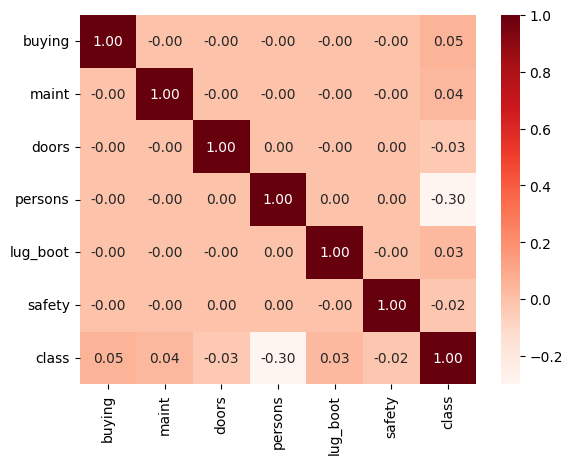

In [ ]:
# Vẽ ma trận tương quan giữa các thuộc tính
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='Reds')

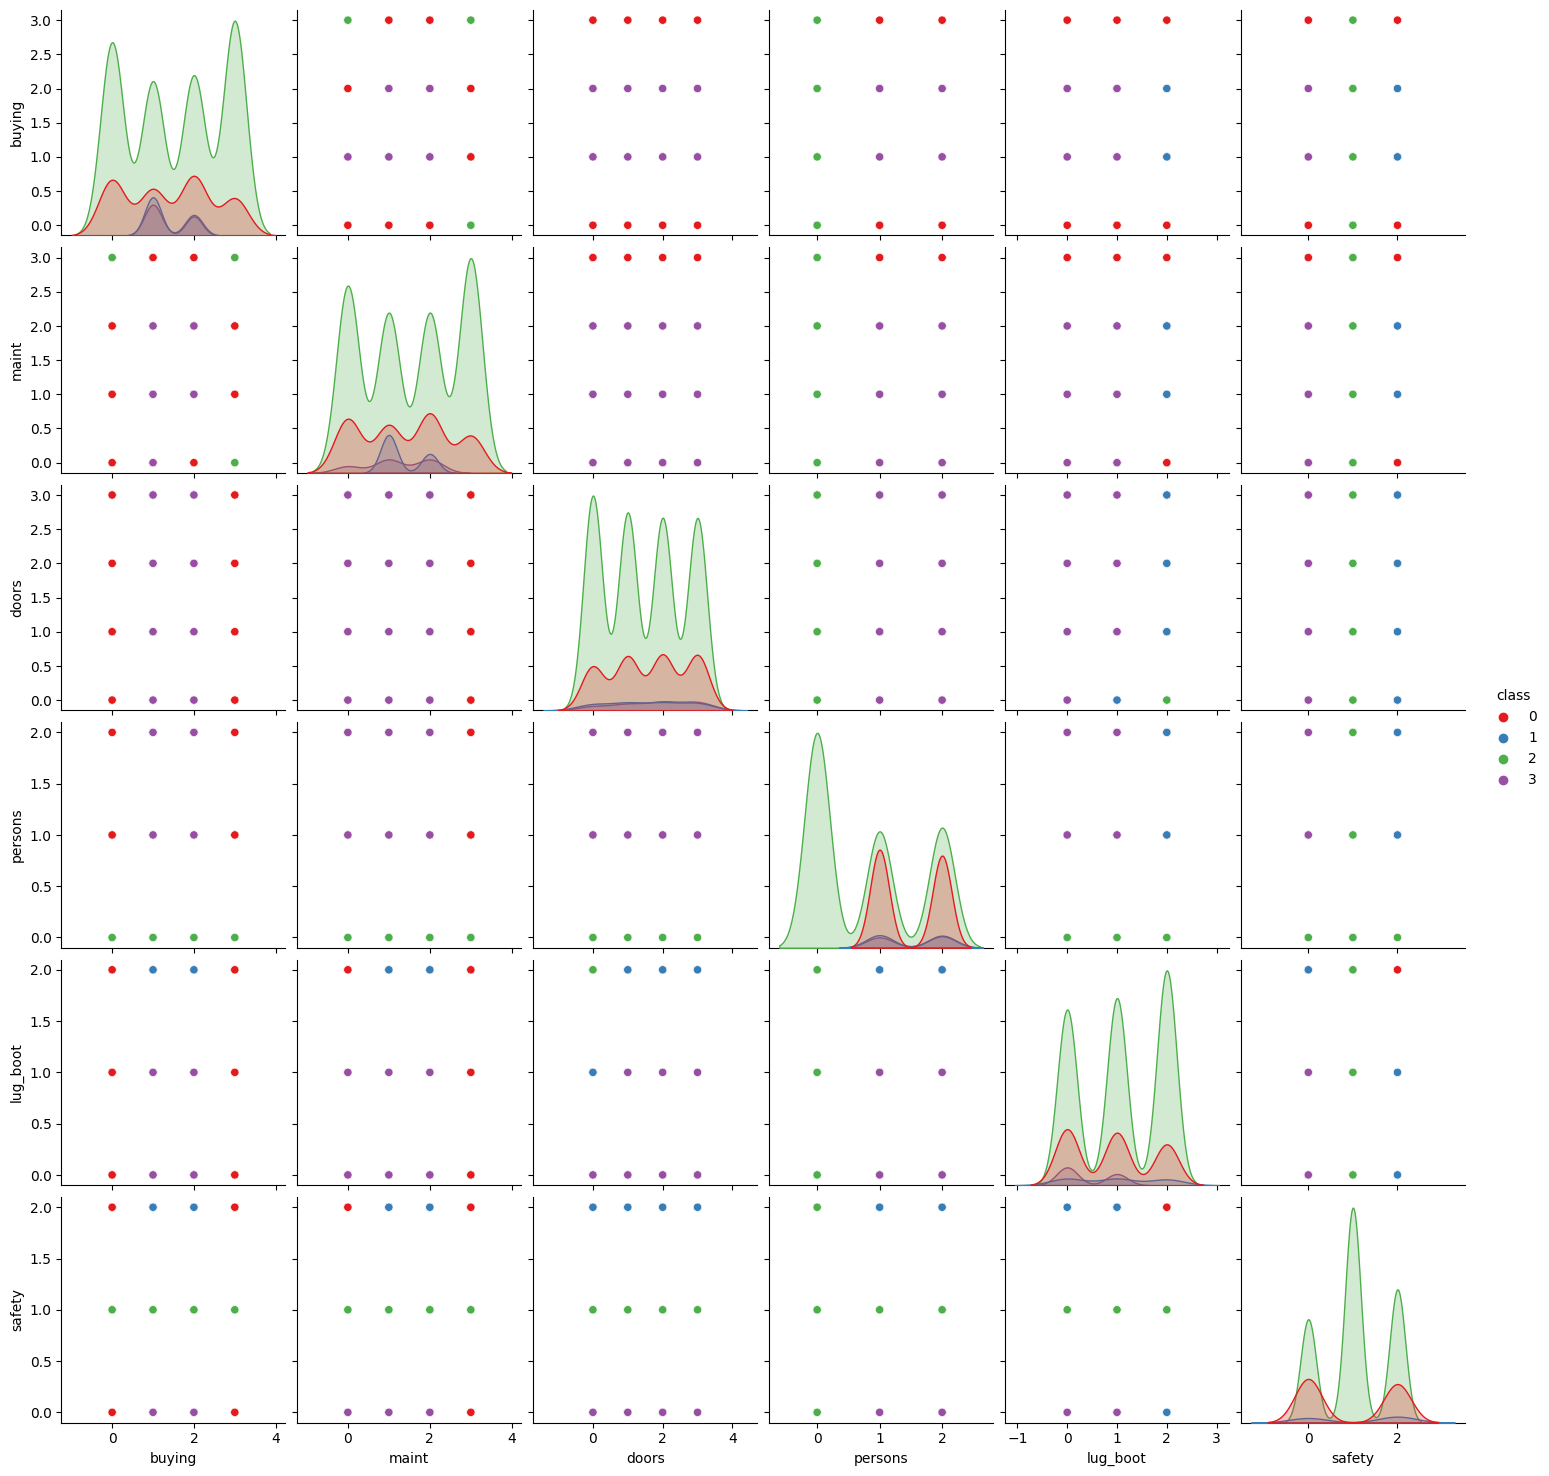

In [ ]:
# Vẽ biểu đồ matrix scatter xem mối quan hệ tuyến tính giữa các thuộc tính
sns.pairplot(data, hue='class', palette='Set1');

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

class DecisionTreeID3:
    def __init__(self, deep_limit=500):
        self.tree = None
        self.deep_limit = deep_limit


    def fit(self, X, y):
        X_ = np.array(X)
        y_ = np.array(y)

        self.tree = self._build_tree(X_, y_)

    def _entropy(self, y):
        counts = np.bincount(y)
        p = counts / len(y)
        p[p==0]=1
        return -p @ np.log(p)

    def _information_gain(self, X, y, feature):
        entropy_total = self._entropy(y)
        weighted_entropy = 0

        for value in set(X[:, feature]):
            subset_y = y[X[:, feature] == value]
            weighted_entropy += len(subset_y) / len(y) * self._entropy(subset_y)

        return entropy_total - weighted_entropy
        # return -weighted_entropy

    def _best_split(self, X, y):
        best_feature = 0
        best_gain = -1

        for feature in range(X.shape[1]):
            gain = self._information_gain(X, y, feature)
            if gain > best_gain:
                best_feature = feature
                best_gain = gain
        # print(best_feature, best_gain)

        return best_feature

    def _build_tree(self, X, y):
        if len(set(y)) == 1:  return y[0]
        if X.shape[1] == 0 or self.deep_limit < 0: return np.bincount(y).argmax()

        best_feature =  self._best_split(X, y)
        tree = {best_feature: {}}

        for value in set(X[:, best_feature]):
            indices = X[:, best_feature] == value
            X_subset, y_subset = X[indices], y[indices]
            # print("Best feature", best_feature, value)
            self.deep_limit-=1
            # print(self.deep_limit)
            tree[best_feature][value] = self._build_tree(X_subset, y_subset)
            # print(tree)

        return tree

    def predict(self, X):
        X_ = np.array(X)
        pred = [self._predict_one_point(x, self.tree) for x in X_]
        return np.array(pred)

    def _predict_one_point(self, x, tree):
        if isinstance(tree, dict):
            feature = list(tree.keys())[0]
            value = x[feature]
            subtree = tree[feature].get(value, None)
            # print(subtree)
            if not isinstance(subtree, dict):
              if not subtree is None:
                return subtree
              return np.bincount(y).argmax()
            return self._predict_one_point(x, subtree)
        else:
            return tree


def evaluate(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  confusion = confusion_matrix(y_test, y_pred)

  print(f'Accuracy: {accuracy:.2f}')
  sns.heatmap(confusion, annot=True, fmt="d", cmap="Greens")
  plt.title("Confusion Matrix")
  plt.ylabel("Nhãn thực tế")
  plt.xlabel("Nhãn dự đoán")
  plt.show()

def numeric2discrete(X, list_percentile, print_percentile_values=False):
  X_discrete = np.zeros_like(X)
  for feature in range(X.shape[1]):
    percentile_values = np.percentile(X[:,feature], list_percentile)

    if print_percentile_values==True:
      print('Feature:',feature, '____ Percentile_values:' , percentile_values)

    X_discrete[:,feature] = np.digitize(X[:, feature], bins=percentile_values)
  return X_discrete

# Áp dụng lên tập dữ liệu

In [ ]:
X = data.drop('class', axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Accuracy: 0.87


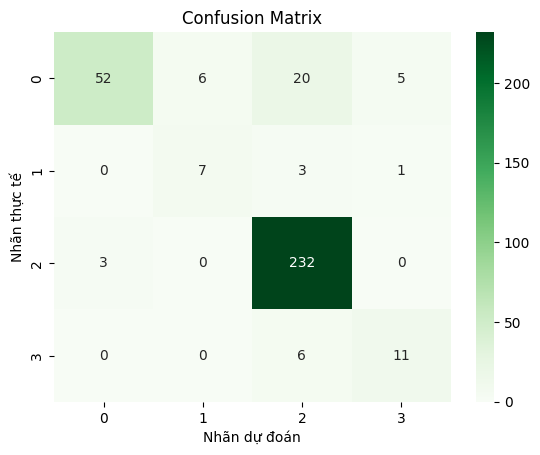

In [ ]:
model = DecisionTreeID3()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

# Trực quan một cây đơn giản

In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/MachineLearning/weather.csv')
weather

,outlook,temperature,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [ ]:
label_encoder = LabelEncoder()
for col in weather.columns:
    weather[col] = label_encoder.fit_transform(weather[col])

weather

,outlook,temperature,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


In [ ]:
X_weather = weather.drop('play', axis=1)
y_weather = weather['play']

model.fit(X_weather, y_weather)
model.tree

{0: {0: 1, 1: {3: {0: 1, 1: 0}}, 2: {2: {0: 0, 1: 1}}}}

> Hình ảnh cây quyết định với tập Weather:

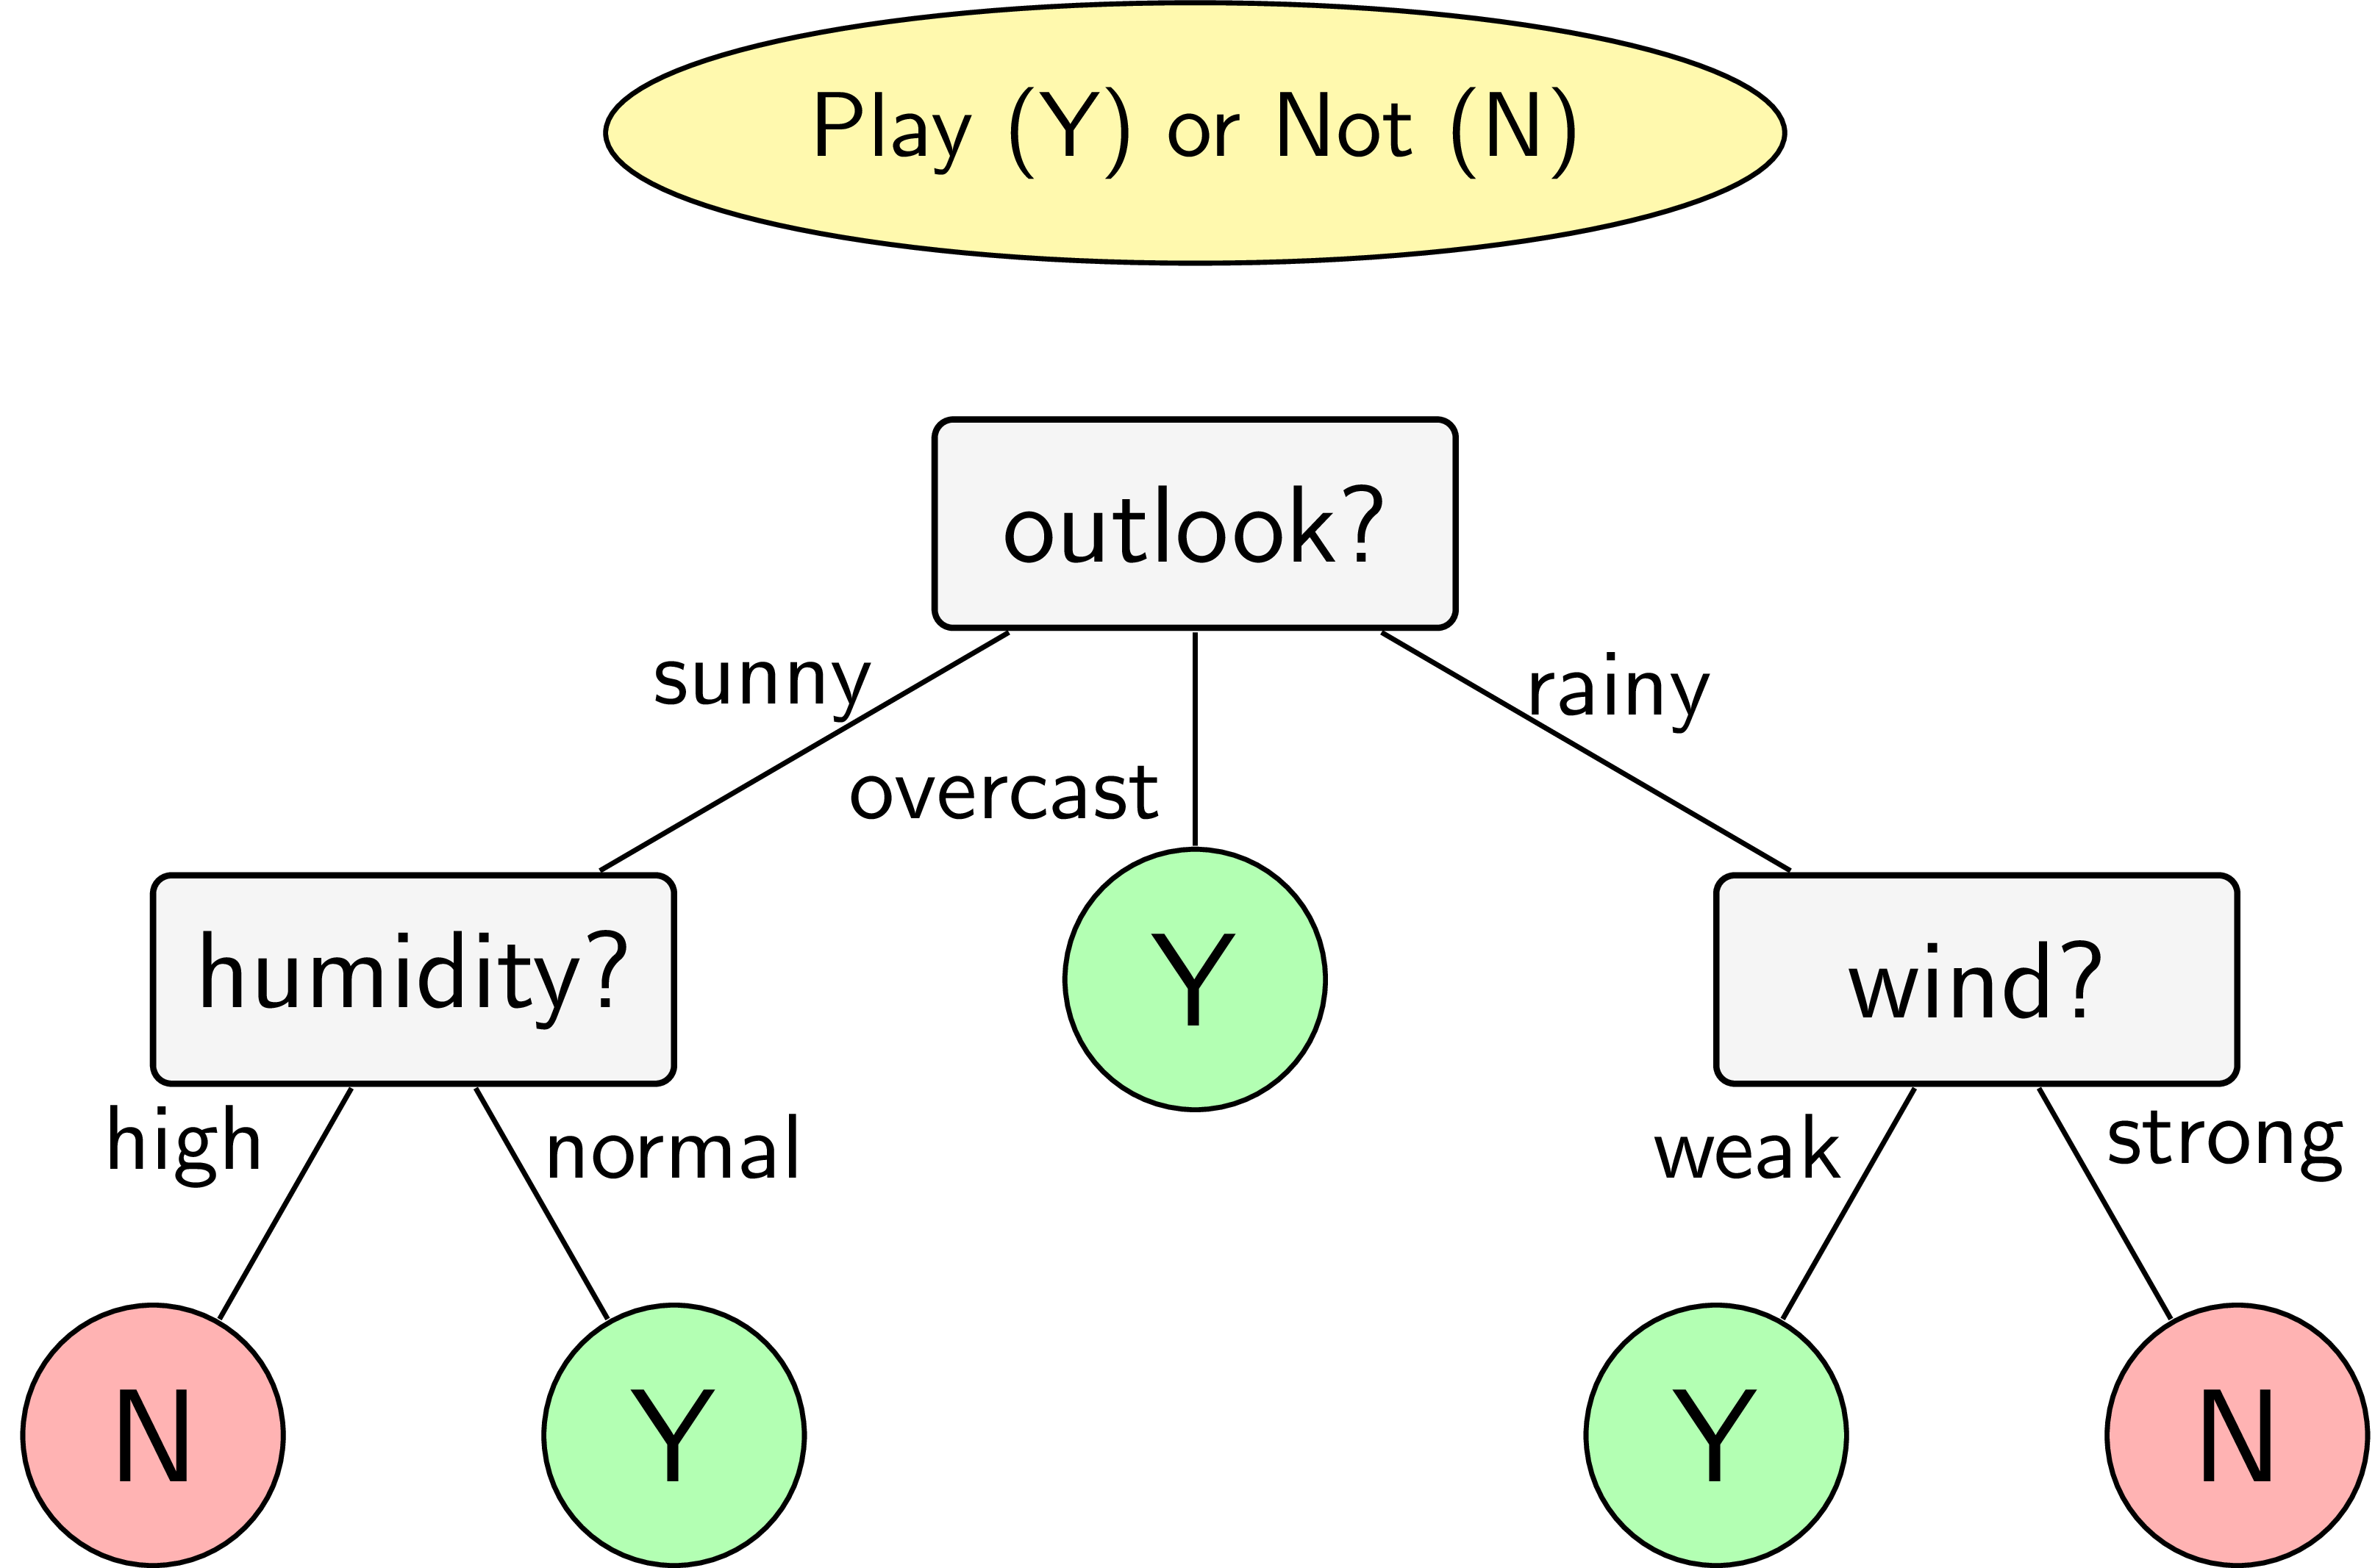


**Nhận xét**: Hình ảnh cây quyết định thực hiện thủ công và kết quả từ code không có sự khác biệt

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_discrete = numeric2discrete(X, [25,75,100])
X_discrete[0:5]

array([[1., 2., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 2., 0., 0.]])

In [ ]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [ ]:
iris.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


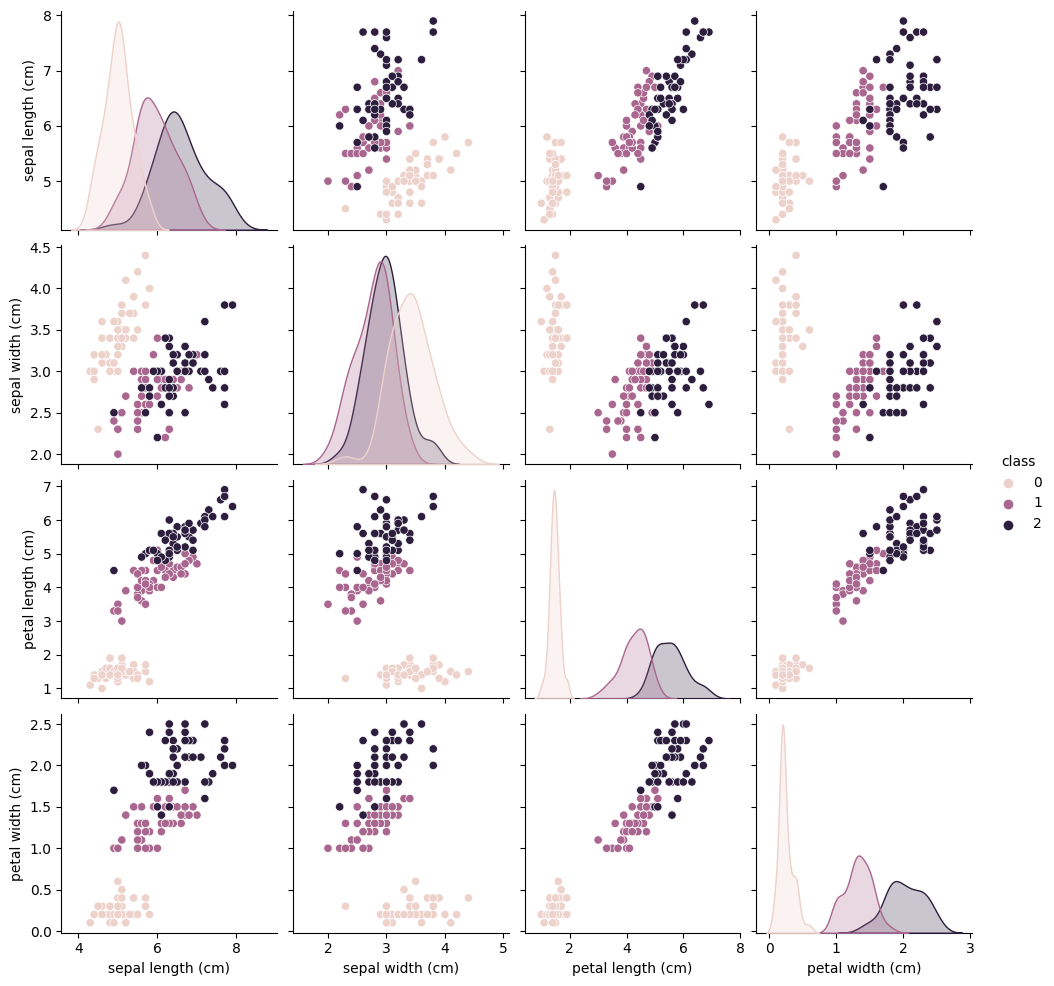

In [ ]:
# Trực quan hóa dữ liệu theo từng lớp
iris = pd.DataFrame(data=X, columns=iris.feature_names)
iris['class'] = y
sns.pairplot(iris, hue='class')

Text(0.5, 1.0, 'Ma trận tương quan các thuộc tính')

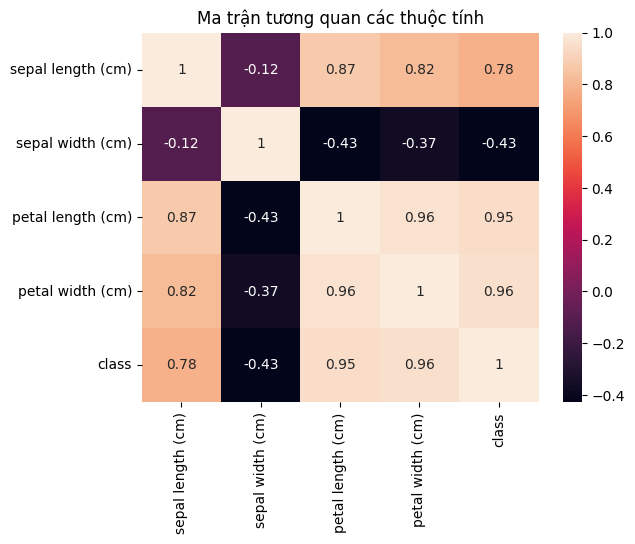

In [ ]:
# Sử dụng heatmap để kiểm tra xem các thuộc tính nào có thể có mối liên hệ với nhau
sns.heatmap(iris.corr(), annot=True)
plt.title('Ma trận tương quan các thuộc tính')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_discrete, y, test_size=0.2, random_state=42)

Accuracy: 0.93


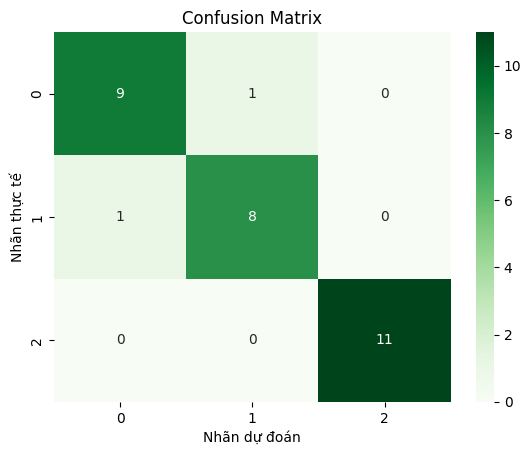

In [ ]:
model = DecisionTreeID3(deep_limit=50)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Accuracy: 0.93


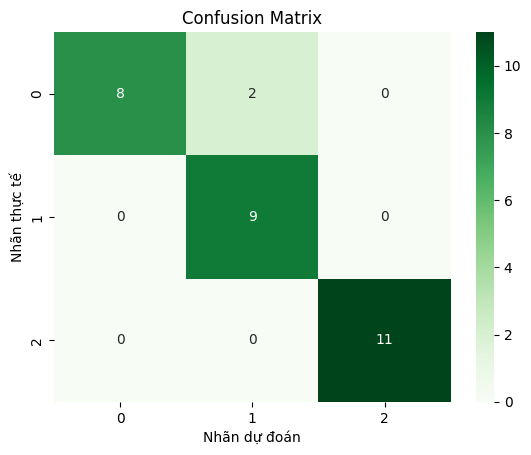

In [ ]:
model = DecisionTreeID3(deep_limit=50)
model.fit(X_train[:,2:], y_train)
y_pred = model.predict(X_test[:,2:])
evaluate(y_test, y_pred)

# Thử nghiệm phân loại ảnh

In [ ]:
import os
import cv2

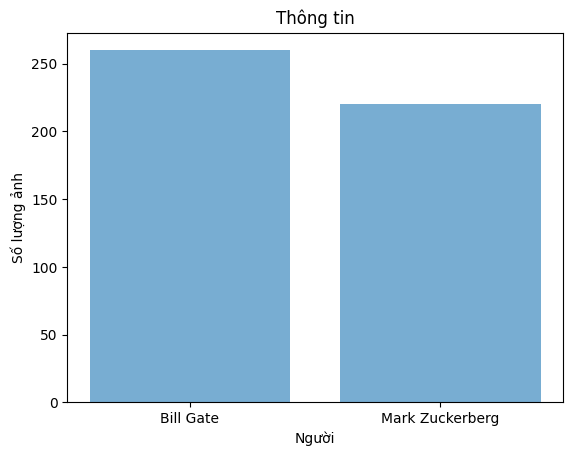

In [ ]:
bill_gate_dir = '/content/drive/MyDrive/DeepLearning/Hw2/data/train/Bill_Gate'
mark_dir = '/content/drive/MyDrive/DeepLearning/Hw2/data/train/Mark_Zuckerberg'

# Tiền xử lý dữ liệu,  hiển thị các thông tin về bộ dữ liệu bằng các biểu đồ trực quan
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

# Resize dữ liệu
bill_gate_images = load_images(bill_gate_dir)
bill_gate_images = [cv2.resize(img, (128, 128)) for img in bill_gate_images]

mark_images = load_images(mark_dir)
mark_images = [cv2.resize(img, (128, 128)) for img in mark_images]

plt.bar(["Bill Gate", "Mark Zuckerberg"], [len(bill_gate_images), len(mark_images)], alpha=0.6)
plt.xlabel('Người')
plt.ylabel('Số lượng ảnh')
plt.title('Thông tin')
plt.show()

In [ ]:
# Hàm xoay ảnh và tạo dữ liệu tăng cường
def increase_images(images, angles):
    incr_images = []
    for image in images:
        incr_images.append(image)
        for angle in angles:
            image = cv2.rotate(image, angle)
            incr_images.append(image)
    return incr_images

# Tăng cường dữ liệu bằng cách xoay ảnh
bill_gate = increase_images(bill_gate_images, [0, 1])
mark = increase_images(mark_images, [0, 1])

# Hiển thị thông tin sau khi tăng cường dữ liệu
print("Bill Gate images:", len(bill_gate_images))
print("Bill Gate images increased:", len(bill_gate))
print("Original Mark images:", len(mark_images))
print("Mark images increased:", len(mark))

Bill Gate images: 260
Bill Gate images increased: 780
Original Mark images: 220
Mark images increased: 660


In [ ]:
# Gán nhãn cho các loại ảnh
bill_gate_labels = np.zeros(len(bill_gate))
mark_labels = np.ones(len(mark))

# Kết hợp dữ liệu và nhãn từ cả hai loại ảnh
all_images = np.concatenate((bill_gate, mark), axis=0)
all_labels = np.concatenate((bill_gate_labels, mark_labels), axis=0)

# Chia dữ liệu thành train và test với tỉ lệ 80-20
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42)

# Hiển thị thông tin sau khi chia dữ liệu
print("Total images:", len(all_images))
print("Train images:", len(train_images))
print("Test images:", len(test_images))


Total images: 1440
Train images: 1152
Test images: 288


In [ ]:
from skimage.feature import hog

def extract_features(images):
    features = []
    feature_images = []
    for image in images:
        feature, feature_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                            cells_per_block=(2, 2), visualize=True, multichannel=False)
        features.append(feature)
        feature_images.append(feature_image)
    return np.array(features), feature_images

In [ ]:
# Trích xuất đặc trưng HOG từ tập train và test
train_hog_features, train_hog_imgaes  = extract_features(train_images)
test_hog_features, test_hog_images = extract_features(test_images)

# train_hog_features = np.array(train_hog_features)
# test_hog_features = np.array(test_hog_features)

print("Shape of train HOG features:",train_hog_features.shape)
print("Shape of test HOG features:", test_hog_features.shape)

<ipython-input-29-c26bf1815623>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  feature, feature_image = hog(image, orientations=9, pixels_per_cell=(8, 8),


Shape of train HOG features: (1152, 8100)
Shape of test HOG features: (288, 8100)


In [ ]:
train_hog_features

array([[0.11640473, 0.30863561, 0.27267383, ..., 0.03333846, 0.        ,
        0.        ],
       [0.31497347, 0.11704151, 0.089677  , ..., 0.30742731, 0.30742731,
        0.01467897],
       [0.10691585, 0.14166214, 0.18384212, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02710816, 0.00353999, 0.00447778, ..., 0.22304326, 0.09935567,
        0.0449487 ],
       [0.1444715 , 0.21878468, 0.27234566, ..., 0.14507217, 0.        ,
        0.05409191],
       [0.04453262, 0.        , 0.03320194, ..., 0.0091603 , 0.        ,
        0.02016981]])

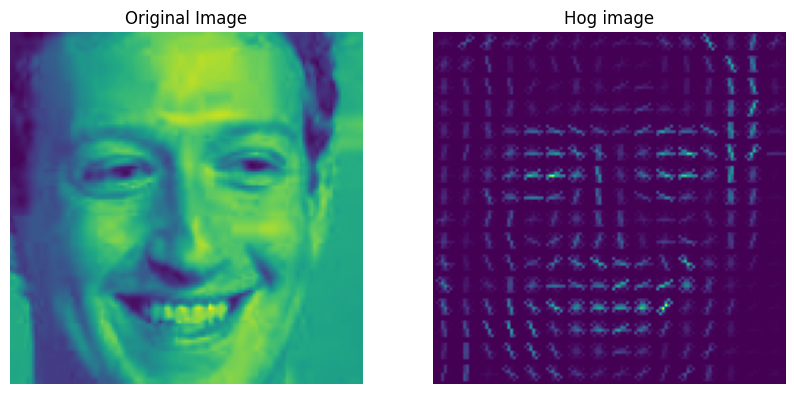

In [ ]:
def display_hog_image(image, hog_image):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(hog_image)
    plt.title('Hog image')
    plt.axis('off')

    plt.show()

display_hog_image(train_images[5], train_hog_imgaes[5]);

In [ ]:
# train_hog_features.shape
list_percnetile = [i for i in range(0,100,20)]
train_hog_features_discrete = numeric2discrete(train_hog_features, list_percnetile)

In [ ]:
model = DecisionTreeID3()
model.fit(train_hog_features_discrete.astype('int64'), train_labels.astype('int64'))

In [ ]:
test_hog_features_discrete = numeric2discrete(test_hog_features, list_percnetile)
y_pred = model.predict(test_hog_features_discrete)

Accuracy: 0.83


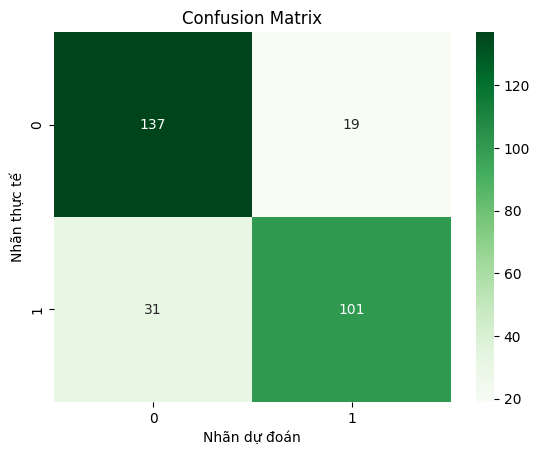

In [ ]:
evaluate(test_labels, y_pred)

# Thử nghiệm trên dữ liệu text

In [ ]:
data_text = pd.read_csv('/content/drive/MyDrive/MachineLearning/Restaurant_Reviews.tsv', delimiter = '\t')
data_text

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [ ]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
data_text['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
list_remove_from_stopwords = ['not', "don't", "doesn't", "isn't", "aren't", "wasn't", "weren't"]
for remove_from_stopwords in list_remove_from_stopwords:
  all_stopwords.remove(remove_from_stopwords)

def pre_progcessing_text_data(text_list):
  corpus = []
  for i in range(len(text_list)):
    review = re.sub('[^a-zA-Z]', ' ',text_list[i])
    review = review.lower()
    review = review.split()
    review = [word for word in review if not word in set(all_stopwords)]
    review = ' '.join(review)
    corpus.append(review)
  return corpus
corpus = pre_progcessing_text_data(data_text['Review'])
corpus[0:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['wow loved place',
 'crust not good',
 'not tasty texture nasty',
 'stopped late may bank holiday rick steve recommendation loved',
 'selection menu great prices']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

texts = [ 'Come hungry, leave happy and stuffed!',
          'First time going but I think I will quickly become a regular.',
          'For service, I give them no stars.',
          'Gave up trying to eat any of the crust (teeth still sore).',
          "I can assure you that you won't be disappointed.",
          'I can take a little bad service but the food sucks.',
          "I don't know what kind it is but they have the best iced tea.",
          'I really enjoyed eating here.',
          "Our server was very nice," +
              "and even though he looked a little overwhelmed with all of our needs," +
              "he stayed professional and friendly until the end.",
          'TOTAL WASTE OF TIME.']

text_pre_progcessing = pre_progcessing_text_data(texts)

cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus + text_pre_progcessing).toarray()
y = data_text.iloc[:, -1].values

In [ ]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1000 non-null   object
 1   Liked   1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
total_samples = sum(1 for line in data_text)
print(f'Total samples: {total_samples}')


Total samples: 2


Accuracy: 0.79


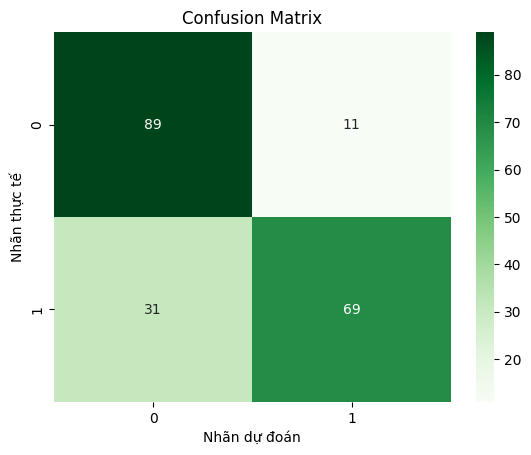

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[0:-len(texts)], y, test_size = 0.2, random_state = 10)

model = DecisionTreeID3()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

In [ ]:
y_pred_ = model.predict(X[-len(texts):])
dict(zip(texts, y_pred_))

{'Come hungry, leave happy and stuffed!': 1,
 'First time going but I think I will quickly become a regular.': 0,
 'For service, I give them no stars.': 0,
 'Gave up trying to eat any of the crust (teeth still sore).': 0,
 "I can assure you that you won't be disappointed.": 1,
 'I can take a little bad service but the food sucks.': 0,
 "I don't know what kind it is but they have the best iced tea.": 1,
 'I really enjoyed eating here.': 0,
 'Our server was very nice,and even though he looked a little overwhelmed with all of our needs,he stayed professional and friendly until the end.': 1,
 'TOTAL WASTE OF TIME.': 0}

In [ ]:
pip install pyvi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 74.7 MB/s eta 0:00:00


In [ ]:
from pyvi import ViTokenizer

# Ví dụ văn bản đầu vào
text = "Mình học lập trình và trả lời câu hỏi."

# Tách từ trong văn bản
tokenized_text = ViTokenizer.tokenize(text)

# In kết quả tách từ
print(tokenized_text)


Mình học lập_trình và trả_lời câu hỏi .


In [ ]:
data_text = pd.read_csv('/content/drive/MyDrive/MachineLearning/data_rating_tiki.csv')
data_text

,product_id,rating,content
0,187827003,5,5* vì Tiki giao sách chất lượng \n\nNội dung: ...
1,187827003,1,Bên shop gói hàng cực kì sơ sài như hình không...
2,187827003,5,"""Vô thường là nhìn vào thực tại trong khía cạn..."
3,187827003,5,Mình đọc đánh giá nhiều bạn nói chất lượng gói...
4,187827003,5,"- Mình bất ngờ bởi bìa sách siêu sắc nét, mỗi ..."
...,...,...,...
30093,76013378,5,NaN
30094,76013378,5,NaN
30095,76013378,5,NaN
30096,76013378,5,NaN


In [ ]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30098 entries, 0 to 30097
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   product_id  30098 non-null  int64 
 1   rating      30098 non-null  int64 
 2   content     19254 non-null  object
dtypes: int64(2), object(1)
memory usage: 705.5+ KB


In [ ]:
data_text['rating'].value_counts()

5    24981
4     2957
3      887
1      788
2      485
Name: rating, dtype: int64

In [ ]:
data_text = data_text.dropna()
data_text = data_text[data_text['rating']<5][data_text['rating']!=3].reset_index()[['rating', 'content']]
data_text

In [ ]:
data_text['rating'].value_counts()

4    2145
1     788
2     485
Name: rating, dtype: int64

<Axes: >

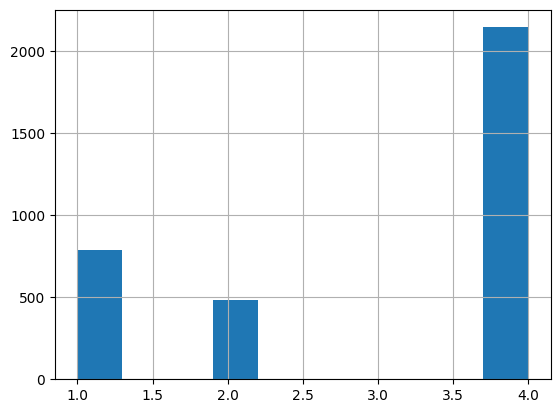

In [ ]:
data_text['rating'].hist()

In [ ]:
def map_rating_to_class(rating):
    if rating >= 4:
        return 1
    else:
        return 0

# Áp dụng hàm map_rating_to_class cho cột 'rating' trong DataFrame
data_text['class'] = data_text['rating'].apply(map_rating_to_class)
data_text

,rating,content,class
0,1,Bên shop gói hàng cực kì sơ sài như hình không...,0
1,4,Sách đẹp và hay. Nhưng mik k hài lòng là hàng ...,1
2,1,Sản phẩm bị rách bìa . Đề nghị đổi lại cuốn sá...,0
3,4,"Giao hàng đúng hạn, đóng gói bình thường, sách...",1
4,1,"Sách nhăn giấy, gãy gáy, bìa bị trầy do lật gi...",0
...,...,...,...
3413,4,Nội dung thú vị,1
3414,4,"Giao sách rất nhanh, chất lượng giấy rất tốt, ...",1
3415,1,"Sach cắt ẩu, tệ lắm luôn đó",0
3416,4,Chất lượng sản phẩm tốt.\nThời gian giao hàng ...,1


In [ ]:
data_text['class'].value_counts()

1    2145
0    1273
Name: class, dtype: int64

In [ ]:
import re
from pyvi import ViTokenizer
vietnamese_adjectives =['đẹp', 'xấu', 'nhanh', 'chậm', 'lớn', 'nhỏ', 'tốt', 'xấu',
                        'mạnh', 'yếu', 'cao', 'thấp', 'khó', 'dễ', 'nhiều', 'ít',
                        'lạnh', 'nóng', 'sáng', 'tối', 'gần', 'xa', 'đắt', 'rẻ',
                        'mỹ', 'xinh', 'dữ', 'tươi', 'mắc', 'buồn', 'trẻ', 'già',
                        'sạch', 'bẩn', 'đau', 'vui', 'ok', 'hay', 'dở', 'ổn', 'tuyệt']



def pre_progcessing_text_data(text_list):
  corpus = []
  for i in range(len(text_list)):
    review = re.sub('[^\w.,\s]', ' ',text_list[i])
    review = review.lower()
    review = ViTokenizer.tokenize(review)
    review = review.split()
    review = [word for word in review if word in vietnamese_adjectives or '_' in word]
    review = ' '.join(review)
    corpus.append(review)
  return np.array(corpus)
corpus = pre_progcessing_text_data(data_text['content'])

In [ ]:
# for i in range(len(corpus)):
#   if corpus[i]=='':
#     print(i , data_text['content'][i])
corpus==''

array([False, False, False, ...,  True, False,  True])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = data_text.iloc[:, -1].values

In [ ]:
# combine_data = pd.DataFrame(np.column_stack((X, y)))
# correlation = combine_data.corr()[1500]
# correlation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Accuracy: 0.69


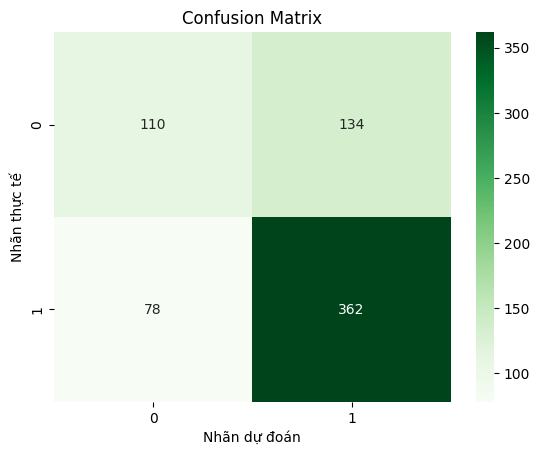

In [ ]:
model = DecisionTreeID3()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)